## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree

## Data Preprocessing

First, we read in the dataset.

In [2]:
#| label: dataset-preview
df = pd.read_csv("../data/solar.csv")
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
0,0,25.896492,-97.460358,Texas,large_community,5.634079,39,5.00,0.235,90633.862770,21.276596,6132.00,4782960.0
1,1,26.032654,-97.738098,Texas,small_utility,5.616413,39,5.00,0.234,91307.484990,21.367521,6132.00,4782960.0
2,2,26.059063,-97.208252,Texas,small_community,5.746738,39,0.15,0.239,2621.097459,0.627615,183.96,143488.8
3,3,26.078449,-98.073364,Texas,small_utility,5.742196,39,5.00,0.239,87439.036330,20.920502,6132.00,4782960.0
4,4,26.143227,-98.311340,Texas,small_utility,5.817187,39,5.00,0.242,85241.850210,20.661157,6132.00,4782960.0


Now, we must shuffle the datasets to reduce bias.

In [3]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
4326,4326,34.633976,-106.361832,New Mexico,medium_residential,6.288012,34,0.010,0.262,1.456789e+02,0.038168,12.264,8.339520e+03
4006,4006,34.576786,-102.597473,Texas,small_residential,6.425785,39,0.005,0.268,6.968194e+01,0.018657,6.132,4.782960e+03
9751,9751,37.820488,-105.240173,Colorado,large_residential,6.112310,38,0.015,0.255,2.309707e+02,0.058824,18.396,1.398096e+04
11363,11363,46.366371,-123.463028,Washington,large_utility,3.726862,50,2000.000,0.155,8.309334e+07,12903.225810,2452800.000,2.452800e+09
3362,3362,32.793304,-114.747818,California,small_community,6.840104,41,0.150,0.285,1.846694e+03,0.526316,183.960,1.508472e+05


Looking at each dataset, we can identify which variables we want to use for our models.

In [4]:
X = df.loc[:, ['lat','long','capacity']]
y = df.loc[:, ['generated_energy','cost']]

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [5]:
X_train = X[:9500]
X_test = X[9500:]
y_train = y[:9500]
y_test = y[9500:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [6]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-0.1222636 , -0.72300137, -0.43943183],
       [-0.13674851, -0.24165866, -0.43943988],
       [ 0.68480694, -0.57957659, -0.43942379],
       ...,
       [-0.13809139,  0.21964016, -0.43942379],
       [-0.19139052, -0.60332559, -0.43140258],
       [-0.26111264, -0.03741568, -0.43943988]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit.

In [7]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

RandomForestRegressor()

With a trained model, predictions can now be made.

In [8]:
#| label: prediction-comparisons

display = y_test.reset_index()
preds = reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {preds[i][0]:.2f}\tactual energy: {display.at[i, 'generated_energy']:.2f}\tpredicted cost: {preds[i][1]:.2f}\tactual cost: {display.at[i, 'cost']:.2f}")

Predictions
----------------------
predicted energy: 6132.00	actual energy: 6132.00	predicted cost: 5028240.00	actual cost: 5028240.00
predicted energy: 183.96	actual energy: 183.96	predicted cost: 125092.80	actual cost: 125092.80
predicted energy: 12.26	actual energy: 12.26	predicted cost: 9565.92	actual cost: 9565.92


## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [9]:
#| label: metrics

r2 = metrics.r2_score(y_test, preds, multioutput="raw_values")
rmse = metrics.root_mean_squared_error(y_test, preds, multioutput="raw_values")
mape = metrics.mean_absolute_percentage_error(y_test, preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"r2\t{r2}\nrmse\t{rmse}\nmape\t{mape}")

Metric	Score
-----------------------
r2	[1.         0.99973199]
rmse	[1.84203151e-12 1.00424139e+07]
mape	[9.85642916e-16 4.44841521e-03]


#### Feature Importances

Feature importances give insights into the features that each decision tree in the random forest use to split most often. Results are portrayed in percentages.

In [10]:
#| label: feature-importances

features = ['lat','long','capacity',]

importances = reg.feature_importances_
indices = np.argsort(importances)

print("Importances")
print('----------------------')
for i in indices:
    print(f"{features[i]}: {importances[i]*100}")

Importances
----------------------
long: 0.5023649924964896
lat: 0.7420038684393504
capacity: 98.75563113906416


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [11]:
#| label: k-fold-cross-validation-table

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(reg, X, y, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: 0.9997616578182351
RMSE Average: 6164218.5242848415
MAPE Average: 0.0019807060663228687


,fit_time,score_time,test_r2,test_rmse,test_mape
0,2.986361,0.028260,0.999850,5.233825e+06,0.002174
1,2.941958,0.025449,0.999925,3.747869e+06,0.001545
2,2.504921,0.016603,0.999602,8.273457e+06,0.002129
3,1.747063,0.008211,0.999855,5.241678e+06,0.001733
4,1.723520,0.016229,0.999739,6.765095e+06,0.001984
5,1.695485,0.041037,0.999856,5.101608e+06,0.001929
6,1.725523,0.024756,0.999421,1.033441e+07,0.002599
7,1.841746,0.016647,0.999955,2.943068e+06,0.002000
8,1.801206,0.016318,0.999573,8.606798e+06,0.002018
9,1.834907,0.016288,0.999840,5.394372e+06,0.001695


### Graphs

A graph of the feature importances. This helps to visualize the magnitude of importance of each feature, and compare their impact against one another.

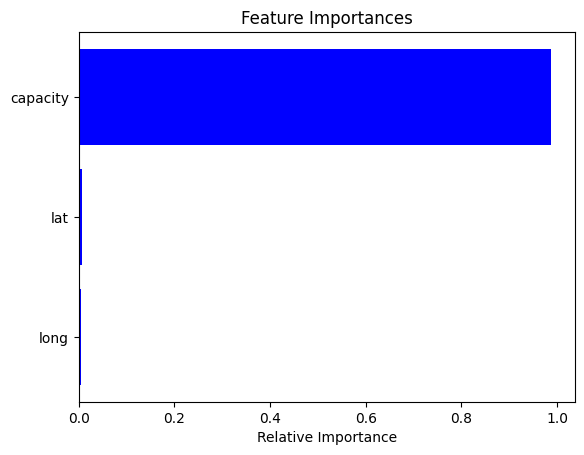

In [12]:
#| label: fig-feature-importances

plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

A graph of one of the decision trees in the random forest. This displays the decision making process the model takes to arive at predictions.

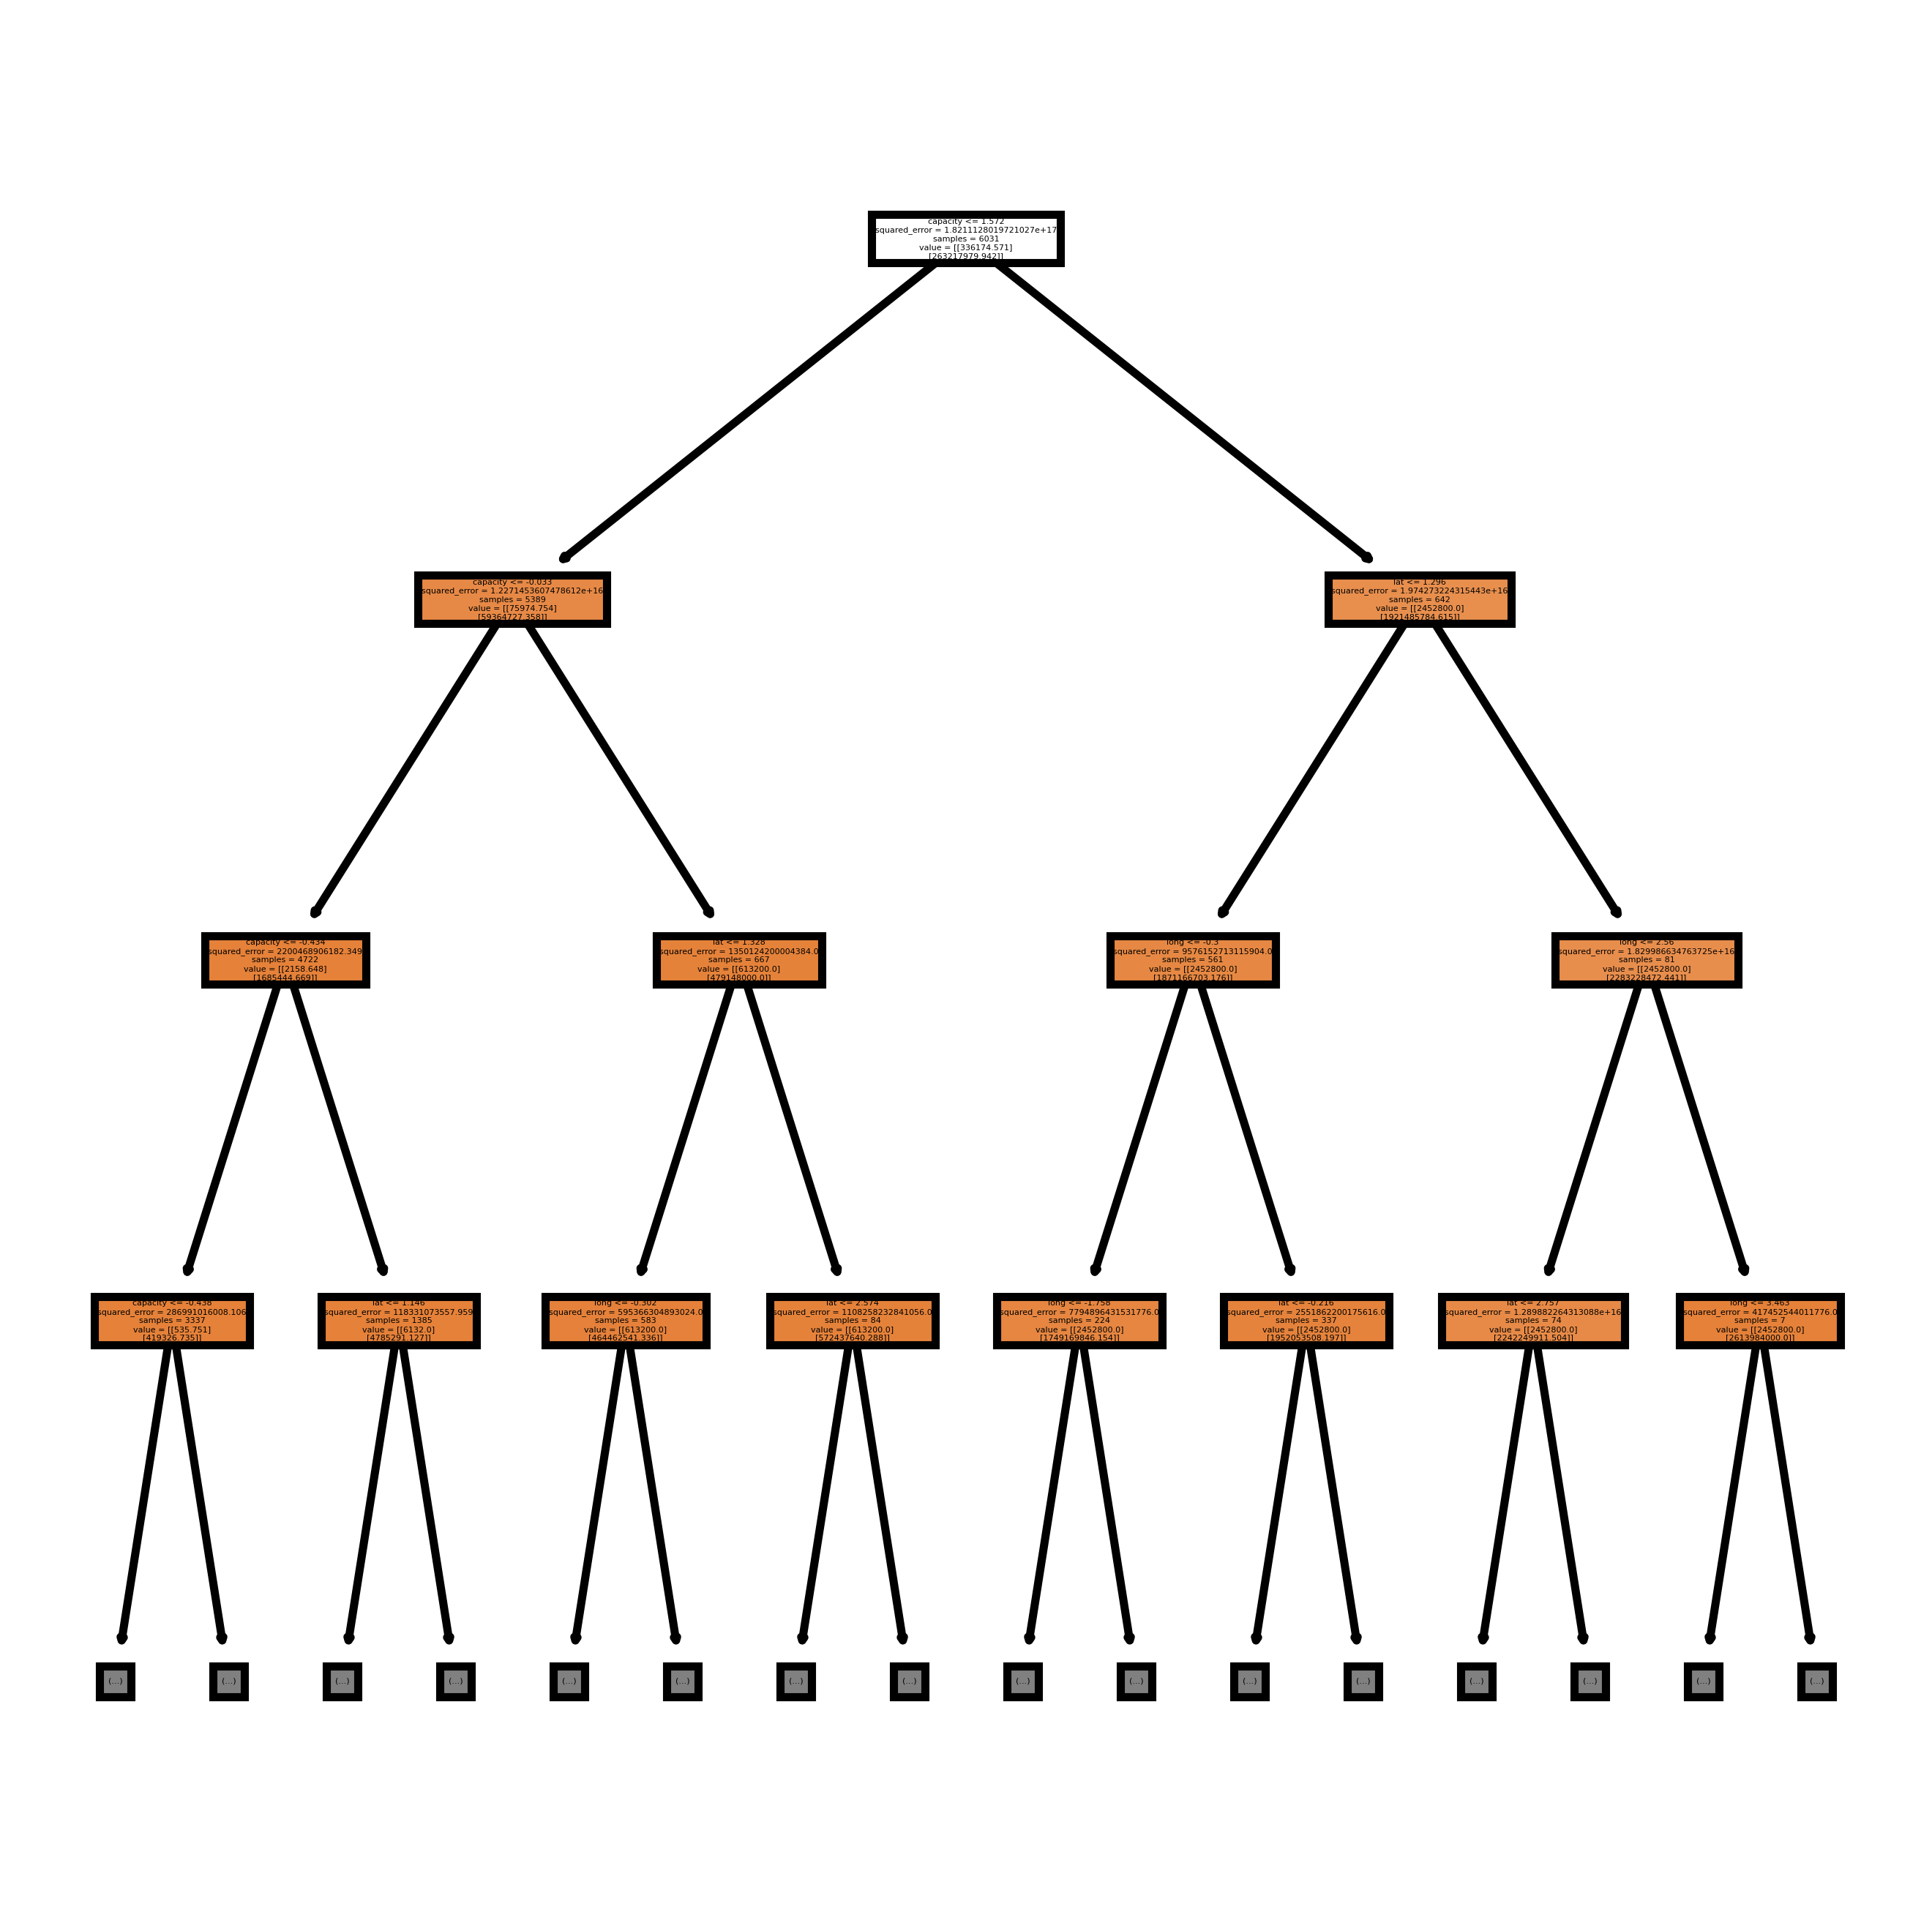

In [13]:
#| label: fig-decision-tree

fn = ['lat','long','capacity']
cn = ['generated_energy','cost']
plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(reg.estimators_[0],feature_names=fn,class_names=cn,filled=True, max_depth=3)
plt.show()